Epoch 1/10, Loss: 0.0549, Accuracy: 64.51%
Epoch 2/10, Loss: 0.0235, Accuracy: 73.89%
Epoch 3/10, Loss: 0.0167, Accuracy: 77.42%
Epoch 4/10, Loss: 0.0139, Accuracy: 79.44%
Epoch 5/10, Loss: 0.0123, Accuracy: 80.81%
Epoch 6/10, Loss: 0.0112, Accuracy: 81.81%
Epoch 7/10, Loss: 0.0105, Accuracy: 82.60%
Epoch 8/10, Loss: 0.0099, Accuracy: 83.24%
Epoch 9/10, Loss: 0.0095, Accuracy: 83.75%
Epoch 10/10, Loss: 0.0092, Accuracy: 84.19%


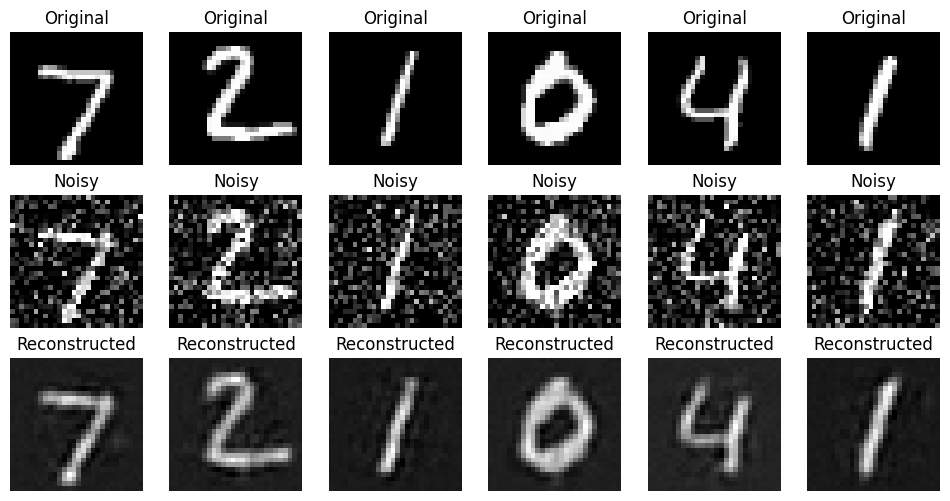

In [3]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.clamp(0,1))
])


# Data Loading (MNIST)
train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_data  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)


# Data Loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)


# Define Autoencoder Architecture
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # -> [16,14,14]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> [32,7,7]
            nn.ReLU(True),
        )

        # Decoder 
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # [16,14,14]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # [1,28,28]
            nn.Linear(28*28, 28*28)  # final linear layer
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder[0:3](x)   # apply ConvTranspose layers first
        x = x.view(x.size(0), -1)  # flatten
        x = self.decoder[3](x)     # Linear layer
        x = x.view(-1, 1, 28, 28)  # reshape back
        return x

model = DenoisingAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# Add Noise Function
def add_noise(img, noise_factor=0.3):
    noisy = img + noise_factor * torch.randn_like(img)
    return noisy.clamp(0., 1.)


# Accuracy Function (pixel-wise similarity)
def reconstruction_accuracy(output, target, tol=0.1):
    # Count pixels where |output-target| < tol
    correct = ((output - target).abs() < tol).float().mean().item()
    return correct * 100


# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for data, _ in train_loader:
        noisy_imgs = add_noise(data)
        outputs = model(noisy_imgs)
        loss = criterion(outputs, data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        train_acc  += reconstruction_accuracy(outputs, data) * data.size(0)

    avg_loss = train_loss / len(train_loader.dataset)
    avg_acc  = train_acc / len(train_loader.dataset)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%")


# Evaluation (Visualize)
model.eval()
with torch.no_grad():
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    noisy_imgs = add_noise(images)
    outputs = model(noisy_imgs)


# Plot original, noisy, reconstructed
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
for i in range(6):
    axes[0, i].imshow(images[i].squeeze(), cmap="gray")
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    axes[1, i].imshow(noisy_imgs[i].squeeze(), cmap="gray")
    axes[1, i].set_title("Noisy")
    axes[1, i].axis("off")

    axes[2, i].imshow(outputs[i].squeeze(), cmap="gray")
    axes[2, i].set_title("Reconstructed")
    axes[2, i].axis("off")

plt.show()
